In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import os

import ipywidgets as widgets
from IPython.display import display


path = "./2"
extetion = ".txt"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

files


['./2/Organic_12.txt',
 './2/Organic_06.txt',
 './2/Organic_09.txt',
 './2/Organic_04.txt',
 './2/Organic_11.txt',
 './2/Organic_15.txt',
 './2/Organic_13.txt',
 './2/Organic_05.txt',
 './2/Organic_08.txt',
 './2/Organic_16.txt',
 './2/Organic_01.txt',
 './2/Organic_14.txt',
 './2/Organic_03.txt',
 './2/Organic_10.txt',
 './2/Organic_02.txt',
 './2/Organic_07.txt']

In [3]:
class RamanSpectrum:

    def __init__(self, filepath, x=None,y=None):
        self.metadata = {}
        self.props = {}
        self.dictcoords = {}

        if (x==None) and (y==None):
            "x and y not give, reading a file instead"

        with open(filepath, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()

        for line in lines:
            if line.startswith("#"):
                key, value = line.strip().split("=")
                self.metadata[key[1:]] = value.replace('\t', '')

        self.metakeys = self.metadata.keys()
        
        self.data = np.loadtxt(lines[len(self.metadata):])
        self.x = self.data[:,0]
        self.y = self.data[:,1]

        self.acquired = self.metadata['Acquired'].replace(' ', '_').replace('.','')
        self.title = self.metadata['Title'].replace(' ','_')

        self.sample = self.title + '/' + self.acquired

        if not os.path.exists(self.sample):
            os.makedirs(self.sample)

        for e in self.data:
            self.dictcoords[e[0]] = e[1]
        
        "self.metadata"
        "self.dictcoords"
        "self.metakeys"
    
    def setprops(self,prop, name):
        self.props[name] = prop
    
    # Create sliders for frequency, amplitude, and plot interval
    def inter(self, X=[],Y=[]):
        if (X==[]) and (Y==[]):
            x = self.x
            y = self.y
        else:
            x=X
            y=Y

        xmin,xmax = min(x),max(x)
        ymin,ymax = min(y),max(y)

        freq_slider = widgets.FloatSlider(min=0.1, max=10, value=1, description='Frequency:')
        amp_slider = widgets.FloatSlider(min=0.1, max=5, value=1, description='Amplitude:')
        x_min_slider = widgets.FloatSlider(min=xmin, max=xmax, value=xmin, description='X min:')
        x_max_slider = widgets.FloatSlider(min=xmin, max=xmax, value=xmax, description='X max:')
        y_min_slider = widgets.FloatSlider(min=ymin, max=ymax, value=ymin, description='Y min:')
        y_max_slider = widgets.FloatSlider(min=ymin, max=ymax, value=ymax, description='Y max:')

        # Function to update the plot based on slider values
        def update_plot(freq, amp, x_min, x_max, y_min, y_max):
            plt.figure(figsize=(4, 3))
            plt.plot(x, y)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.title('Sine Function')
            plt.show()

        # Create interactive widgets
        interactive_plot = widgets.interactive(
            update_plot,
            freq=freq_slider,
            amp=amp_slider,
            x_min=x_min_slider,
            x_max=x_max_slider,
            y_min=y_min_slider,
            y_max=y_max_slider
        )

        # Display the widgets
        display(interactive_plot)
    
    def plotnsave(self,_dir,_show = True,xy=[]):
        cdir = self.sample+'/'+_dir
        if not os.path.exists(cdir):
            os.makedirs(cdir)
        name = cdir+"/{i}.png".format(i = self.metadata['Date'])

        if (xy==[]):
            x = self.x
            y = self.y
        else:
            x=xy[0]
            y=xy[1]

        plt.plot(x,y)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.savefig(name)
        if _show:
            plt.show()
        plt.clf()
    
    def plot(self):
        self.plotnsave('raw_plot')

    def acces_value(self, pattern):
        matched_keys = set()
        regex = re.compile(pattern, re.IGNORECASE)
        for key in self.metakeys:
            if regex.search(key):
                matched_keys.add(key)
        return (matched_keys, [self.metadata[key] for key in matched_keys])
    
    def crop(self, lower, upper, show = False):
        self.croppedx = []
        self.croppedy = []

        for e in self.dictcoords.keys():
            if e > lower and e < upper:
                self.croppedx.append(e)
                self.croppedy.append(self.dictcoords[e])
        self.plotnsave('crop',_show = show, xy=[self.croppedx,self.croppedy])

    def values_close_to(self,ls):
        return self.x[np.isclose(self.x[:, None], ls, atol=0.5).any(axis=1)]
    

    def plotpoints(self, intervals, x = []):
        if x == []:
            x = self.x
            y = self.y
        else:
            y = []
            x = self.values_close_to(x)
            for e in x:
                y.append(self.dictcoords[e])

        xp = []
        yp = []
    
        for interval in intervals:
            xi = self.values_close_to(interval)
            for _ in xi:
                xp.append(_)
                yp.append(self.dictcoords[_])

        plt.plot(x,y)
        plt.plot(xp,yp, 'o',color = 'red')
        return xp,yp;
    
    def fit_intervals(self,lss,od):
        x,y = self.plotpoints(lss)
        fitted = np.polyfit(x, y, od)
        self.chis = np.polyfit(x, y, od, full=True)
        self.fitted = fitted
        # Plotting the first part
        plt.subplot(2, 1, 1)  # Create subplot 1
        plt.plot(self.croppedx, self.croppedy)
        plt.plot(self.croppedx, np.polyval(fitted, self.croppedx))
        plt.xlim(min(self.croppedx), max(self.croppedx))
        ef = abs(max(self.croppedy) - min(self.croppedy))/20
        plt.ylim(min(self.croppedy)-ef, max(self.croppedy)+ef)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('With baseline')
        # Plotting the second part
        plt.subplot(2, 1, 2)  # Create subplot 2
        self.polylx = self.croppedx
        fitedcurve = np.polyval(fitted, self.croppedx)
        self.fitedcurve = fitedcurve
        self.polyly = (self.croppedy - fitedcurve) + abs(min(self.croppedy - fitedcurve))
        plt.plot(self.polylx,self.polyly)
        print(min(self.polyly))
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Without baseline')

        # Saving both plots in the same file
        if not os.path.exists(self.sample+'/polyfit'):
            os.makedirs(self.sample+'/polyfit')
        plt.savefig(self.sample+"/polyfit/{i}.png".format(i=self.metadata['Date']))
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    def polifit(self, a,b,ord = 3):
        x = []
        y = []
        for x_i, y_i in zip(self.croppedx,self.croppedy):
            if x_i < a or x_i > b:
                x.append(x_i)
                y.append(y_i)
        fitted = np.polyfit(x, y, ord)
        self.fitted = fitted
        plt.subplot(2, 1, 1)  
        plt.plot(self.croppedx, self.croppedy)
        plt.plot(self.croppedx, np.polyval(fitted, self.croppedx))
        plt.xlim(min(self.croppedx), max(self.croppedx))
        ef = abs(max(self.croppedy) - min(self.croppedy))/20
        plt.ylim(min(self.croppedy)-ef, max(self.croppedy)+ef)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('With baseline')
        # Plotting the second part
        plt.subplot(2, 1, 2)  # Create subplot 2
        plt.plot(self.croppedx, self.croppedy - np.polyval(fitted, self.croppedx))
        self.polylx = self.croppedx
        self.polyly = self.croppedy - np.polyval(fitted, self.croppedx)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Without baseline')

        # Saving both plots in the same file
        if not os.path.exists(self.sample+'/polyfit'):
            os.makedirs(self.sample+'/polyfit')
        plt.savefig(self.sample+"/polyfit/{i}.png".format(i=self.metadata['Date']))
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    
    def sav_gol(self, window, order, x_arr,y_arr, show=False):
        """
        Takes the x and y values and applies a Savitzky-Golay filter
        sets self.denoisedx and self.denoisedy to the denoised values
        """
        self.denoisedx = []
        self.denoisedy = []    
        self.savgol = savgol_filter(y_arr, window, order)
        self.denoisedx = x_arr
        self.denoisedy = self.savgol
        plt.plot(self.denoisedx, self.denoisedy)
        self.basedx = self.denoisedx
        self.basedy = self.denoisedy
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Denoised')

        if not os.path.exists(self.sample+'/denoised'):
            os.makedirs(self.sample+'/denoised')

        # Saving the cropped data as an image
        name = self.sample + "/denoised/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()

    def baseline(self,degree = 1, show = False, before=False):
        # Fit polynomial baseline

        xfit = self.denoisedx[:5] + self.denoisedx[-5:]
        self.a = list(self.denoisedy[:5])
        self.b = list(self.denoisedy[-5:])
        
        print(self.a)
        print(self.b)

        yfit = self.a + self.b
        print(type(self.denoisedx),type(self.denoisedy))
        print('The lenghts',len(xfit),len(yfit))

        coefficients = np.polyfit(xfit, yfit, degree)
        baseline = np.polyval(coefficients, self.denoisedx)

        # Plot the original signal and the baseline
        # plt.plot(self.denoisedx, self.denoisedy, label='Original Signal')
        new_zero = abs(min(self.denoisedy - baseline))
        if before:
            plt.plot(self.denoisedx, (self.croppedy + new_zero)  , label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        else:
            plt.plot(self.denoisedx, (self.denoisedy + new_zero), label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        self.basedx = self.denoisedx
        self.basedy = (self.denoisedy + new_zero) - baseline
        # plt.plot(self.denoisedx, baseline, label='Baseline')
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Intensity (counts)')

        if not os.path.exists(self.sample+'/baseline'):
            os.makedirs(self.sample+'/baseline')

        plt.title(self.metadata['Date'] + ' - Baseline')
        if show:
            plt.show()
        name = self.sample + "/baseline/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        plt.clf()
    

    # Define the function as the sum of three Gaussian curves
    def gaussian(self, x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

    def multi_peak_fit(self, x, *params):
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)

        for i in range(num_peaks):
            amplitude, center, sigma = params[i*3 : (i+1)*3]
            y_fit += self.gaussian(x, amplitude, center, sigma)
        return y_fit

    
    def get_fitting(self, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
        x = np.array(self.basedx)
        y = np.array(self.basedy)

        yspec = max(y)
        yspec2 = yspec*f2
        yspec3 = yspec*f3

        # Perform the multi-peak fitting
        # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
        initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
        if not os.path.exists(self.sample+'/fit'):
                os.makedirs(self.sample+'/fit')

        popt, pcov = curve_fit(self.multi_peak_fit, x, y, p0=initial_guess)

        # Extract the optimized parameters
        amplitudes = popt[0::3]
        centers = popt[1::3]
        sigmas = popt[2::3]

        for i in range(0,3):
            amp,cen,sig = popt[i*3:(i+1)*3]

        self.fit_props = popt

        # Print the results

        print('Amplitudes: {}'.format(amplitudes))
        print('Centers: {}'.format(centers))
        print('Sigmas: {}'.format(sigmas))

        # Generate the fitted curve
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = self.multi_peak_fit(x_fit, *popt)
        # Plot the original data and the fitted curve
        plt.plot(x, y, 'bo', label='Original Data')
        plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        self.x_fit = x_fit
        self.y_fit = y_fit
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Counts (a.u.)')
        if show:
            plt.show()
        plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
        self.popt = popt
        plt.clf()
    
    def getgaussfit(self, x,y):
        self.gx = x
        self.gy = y
        

    def get_2_fitting(self,sca = 30, f2 = 0.5,c1 = 520,c2 = 500,s1 = 10,s2 = 20,show = False, case = 'crop'):
        if case == 'crop':
            x = np.array(self.croppedx)
            y = np.array(np.array(self.croppedy)-sca)
        else:
            raise AssertionError("Must select c x and y")

        yspec = max(y)
        yspec2 = yspec*f2

        # Perform the multi-peak fitting
        # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
        initial_guess = [yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
        if not os.path.exists(self.sample+'/fit'):
                os.makedirs(self.sample+'/fit')

        popt, pcov = curve_fit(self.multi_peak_fit, x, y, p0=initial_guess)

        # Extract the optimized parameters
        amplitudes = popt[0::2]
        centers = popt[1::2]
        sigmas = popt[2::2]

        for i in range(0,2):
            amp,cen,sig = popt[i*3:(i+1)*3]

        self.fit_props = popt

        # Print the results

        print('Amplitudes: {}'.format(amplitudes))
        print('Centers: {}'.format(centers))
        print('Sigmas: {}'.format(sigmas))

        # Generate the fitted curve
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = self.multi_peak_fit(x_fit, *popt)
        # Plot the original data and the fitted curve
        plt.plot(x, y, 'bo', label='Original Data')
        plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        self.x_fit = x_fit
        self.y_fit = y_fit
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Counts (a.u.)')
        if show:
            plt.show()
        plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
        self.popt = popt
        plt.clf()

In [10]:
test = RamanSpectrum(files[2])


In [11]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)

def fit_raman(raman):
    # Generate some sample data
    x_ = raman.x
    y_ = raman.y

    # Fit the data to the Gaussian function
    popt, pcov = curve_fit(gaussian, x_, y_, p0=[100, 100, 100])

    # Retrieve the optimized parameters
    amplitude, mean, stddev = popt

    y_fit = gaussian(x_, amplitude, mean, stddev)
    y_new = y_ - y_fit

    # Plot the original data and the fitted curve
    plt.plot(x_, y_new - min(y_new) , 'r-', color='cyan',label='Data')
    # plt.plot(xf, y_fit,color='red', label='Fit')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Gaussian Curve Fitting')
    plt.show()
    return x_, y_new - min(y_new)


/tmp/ipykernel_12437/3022778899.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_, y_new - min(y_new) , 'r-', color='cyan',label='Data')


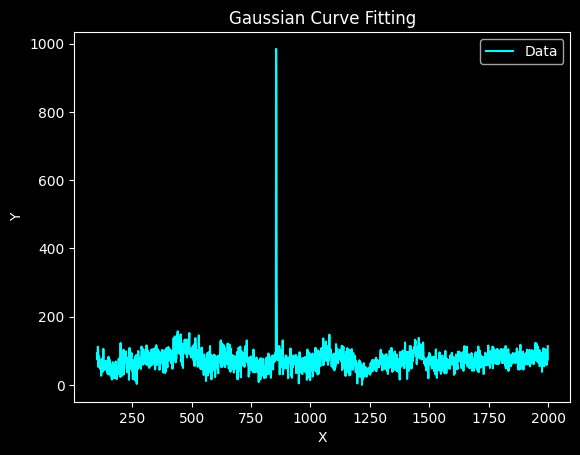

In [12]:
a,b = fit_raman(test)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(x, y, threshold=3):
    # Calculate the mean and standard deviation
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_std, y_std = np.std(x), np.std(y)

    # Compute the Z-scores for each point
    x_z_scores = np.abs((x - x_mean) / x_std)
    y_z_scores = np.abs((y - y_mean) / y_std)

    # Find the indices of points with Z-scores greater than the threshold
    outlier_indices = np.where((x_z_scores > threshold) | (y_z_scores > threshold))[0]

    # Remove the outliers
    x_filtered = np.delete(x, outlier_indices)
    y_filtered = np.delete(y, outlier_indices)

    return x_filtered, y_filtered


# Detect and remove outliers

def plot_removed(a_,b_,t_):
    x_filtered, y_filtered = remove_outliers(a_, b_, threshold=t_)

    # Plotting before and after removing outliers
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(a, b)
    plt.title('Before Removing Outliers')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.subplot(1, 2, 2)
    plt.scatter(x_filtered, y_filtered)
    plt.title('After Removing Outliers')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_12437/3022778899.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_, y_new - min(y_new) , 'r-', color='cyan',label='Data')


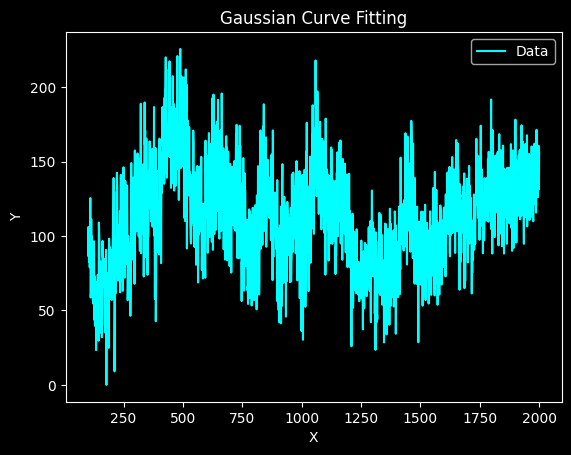

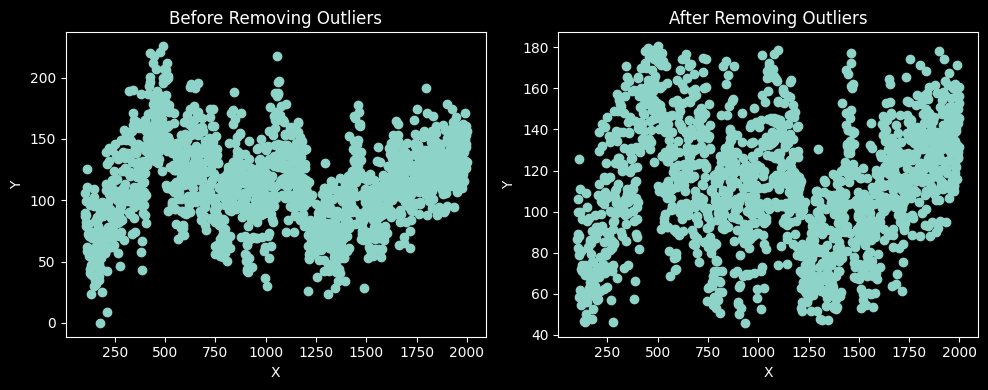

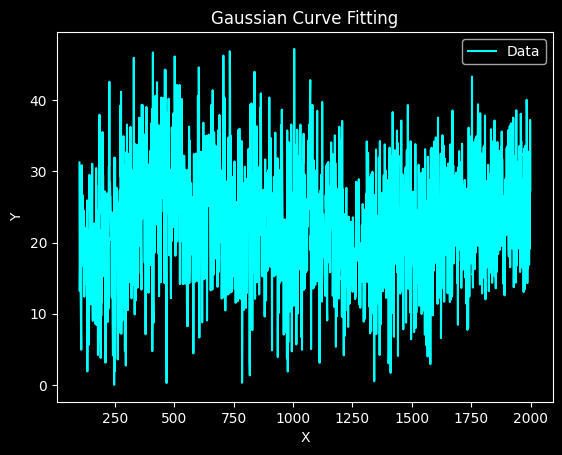

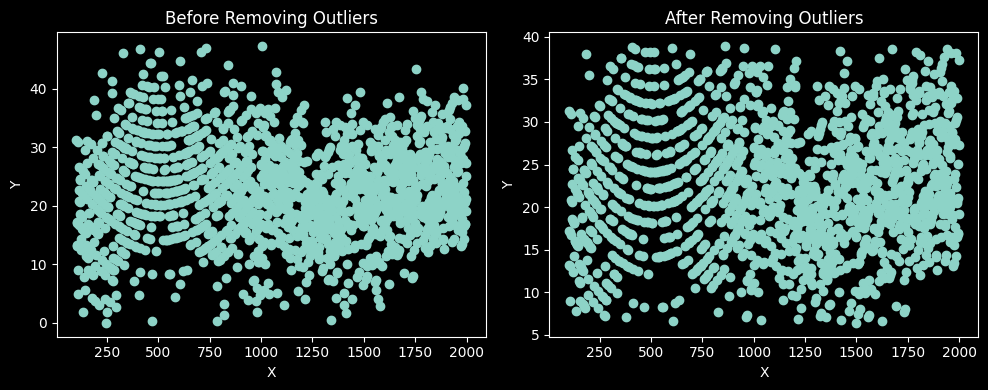

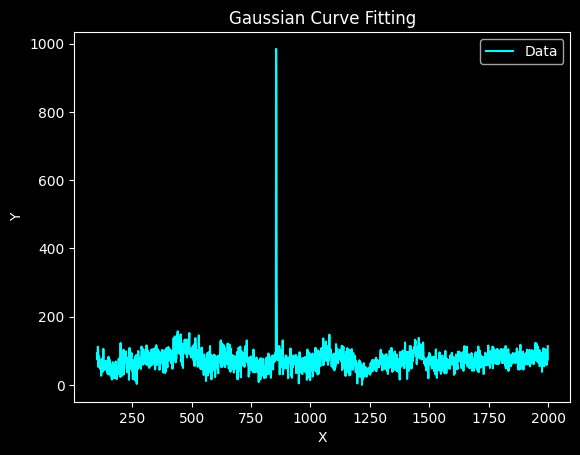

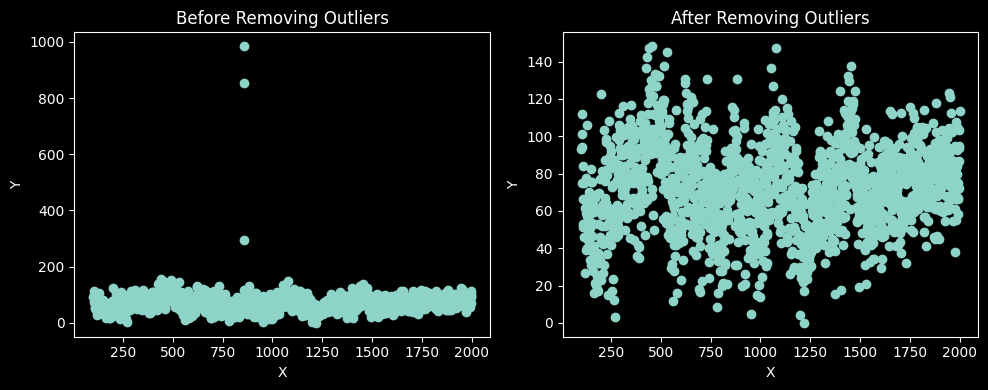

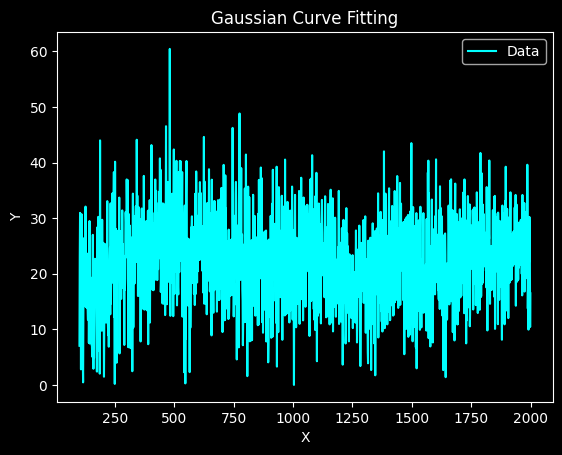

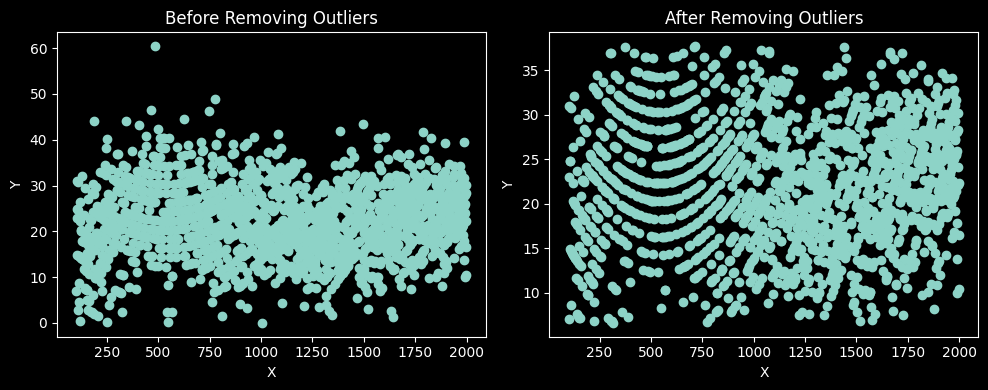

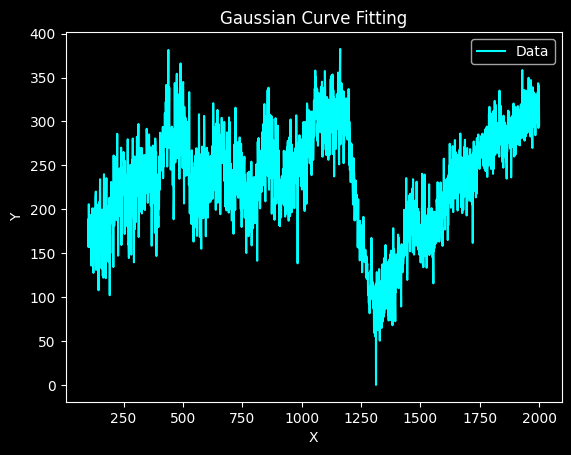

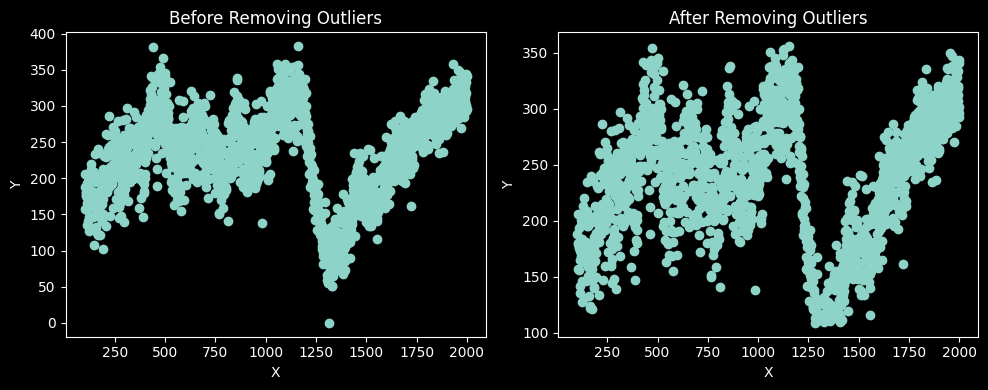

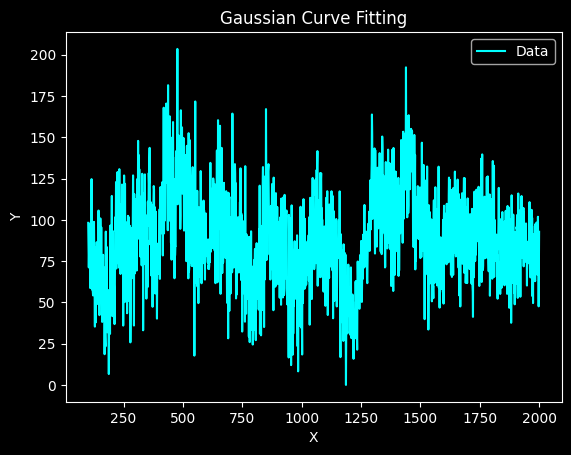

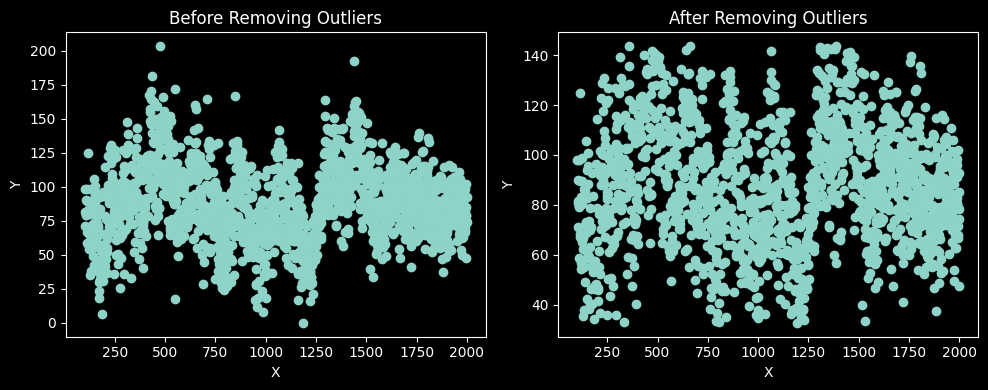

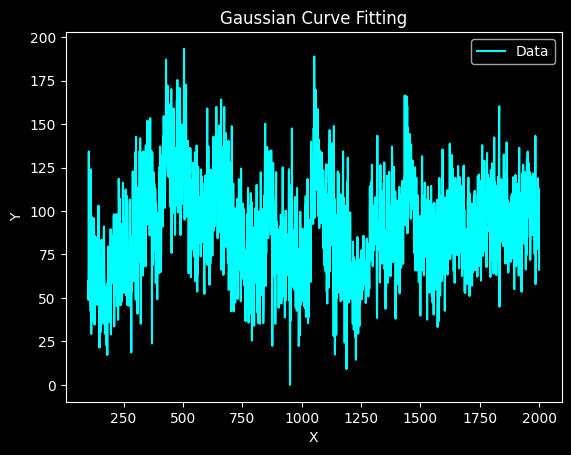

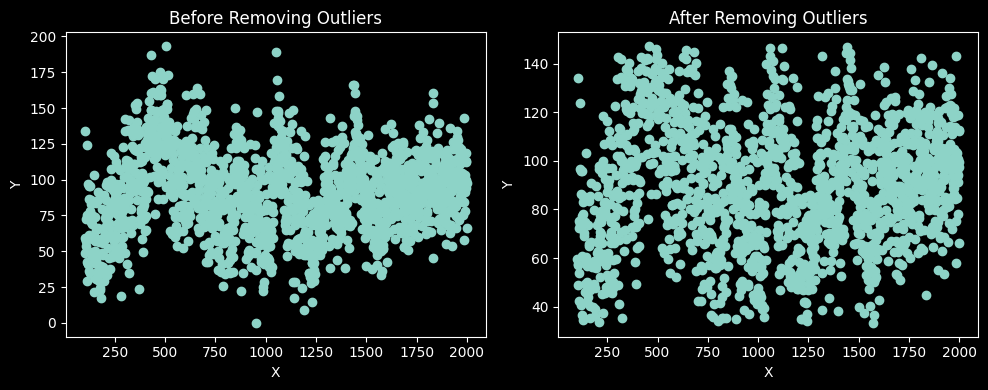

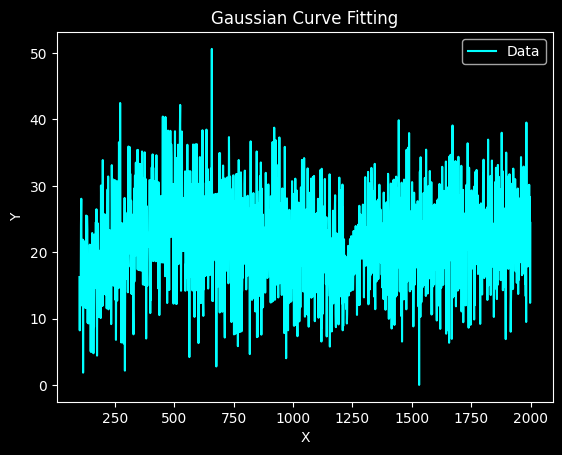

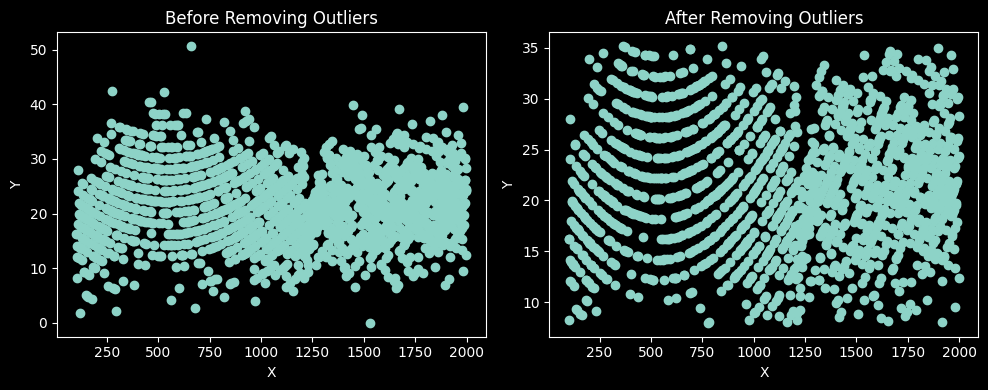

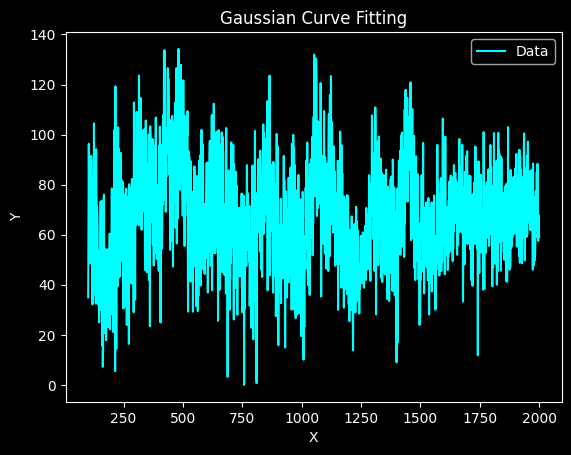

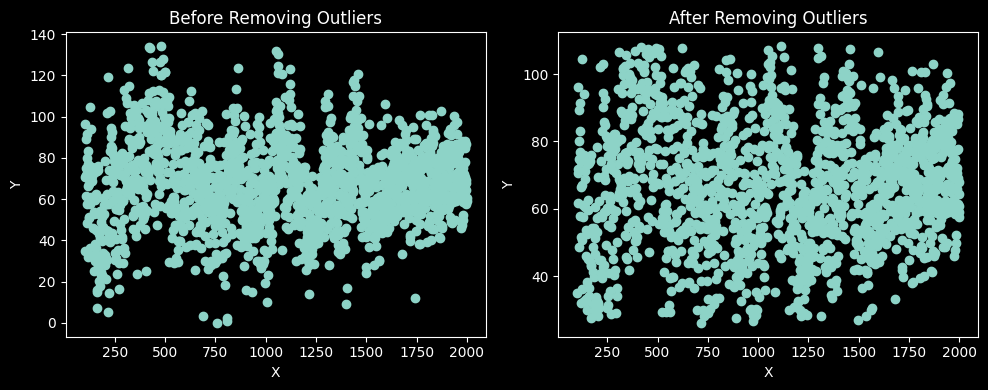

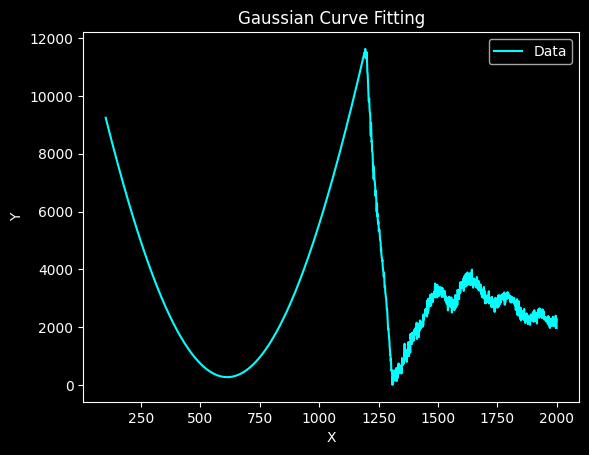

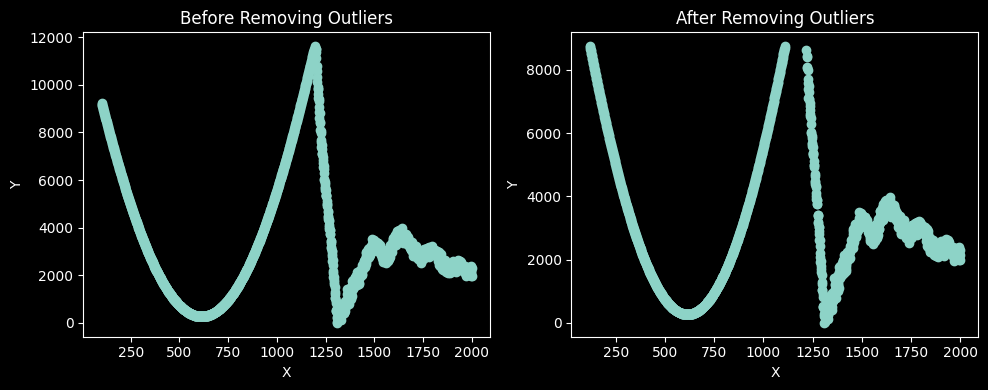

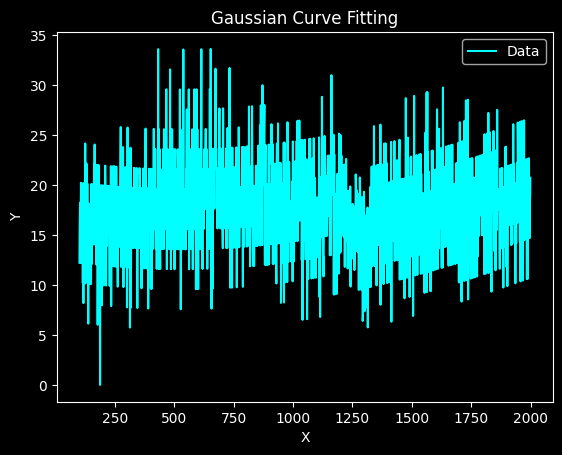

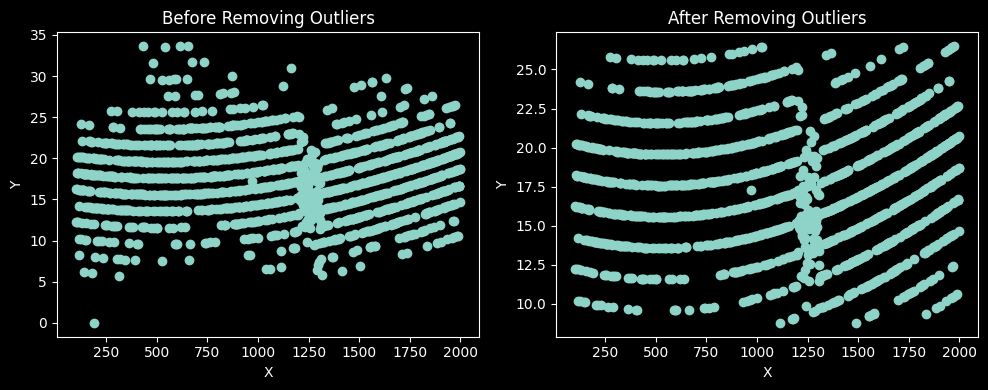

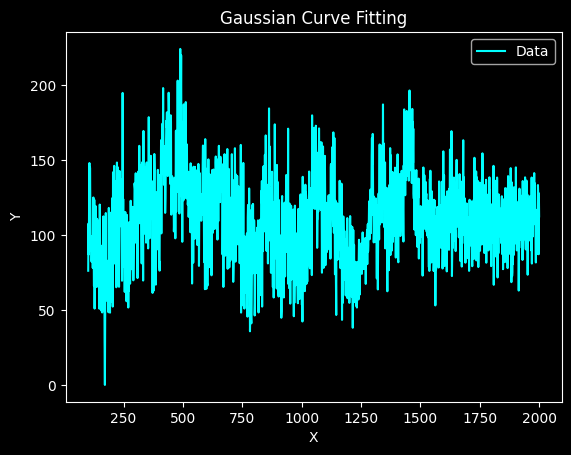

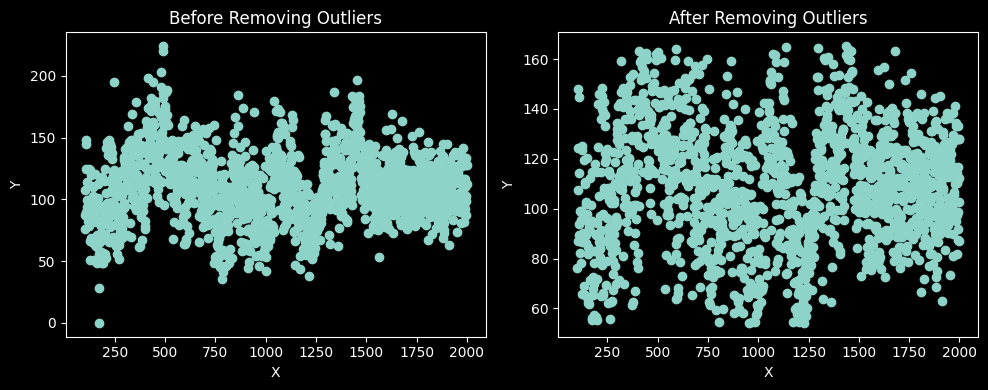

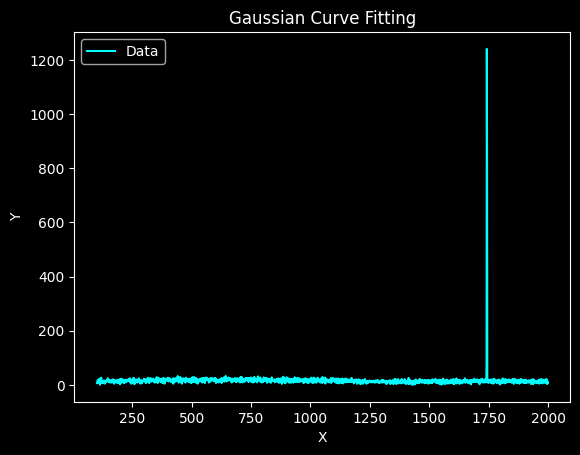

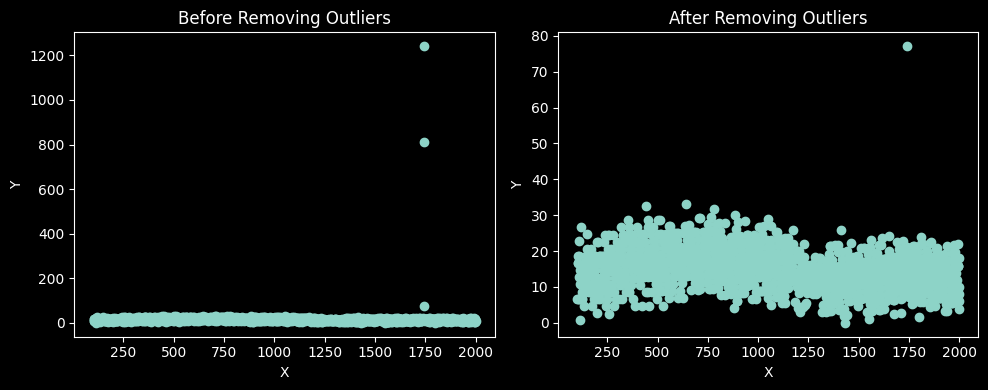

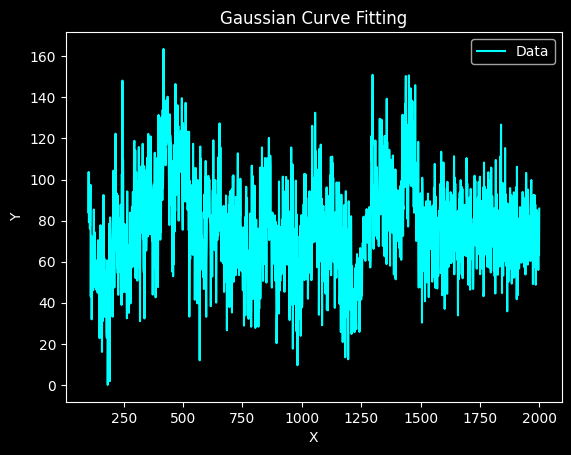

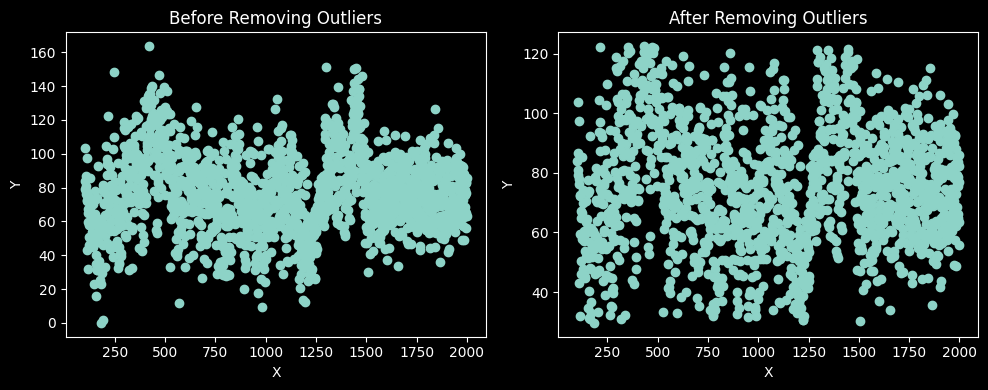

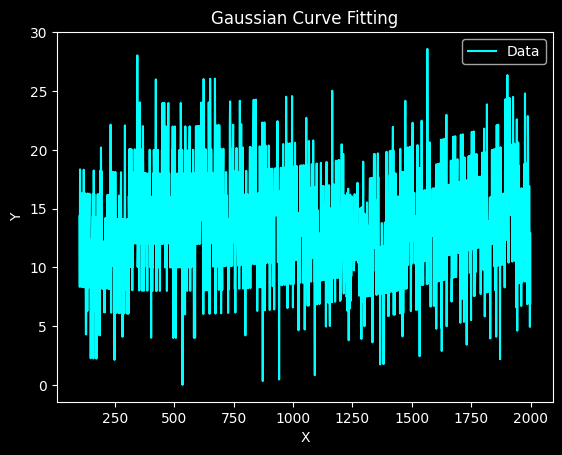

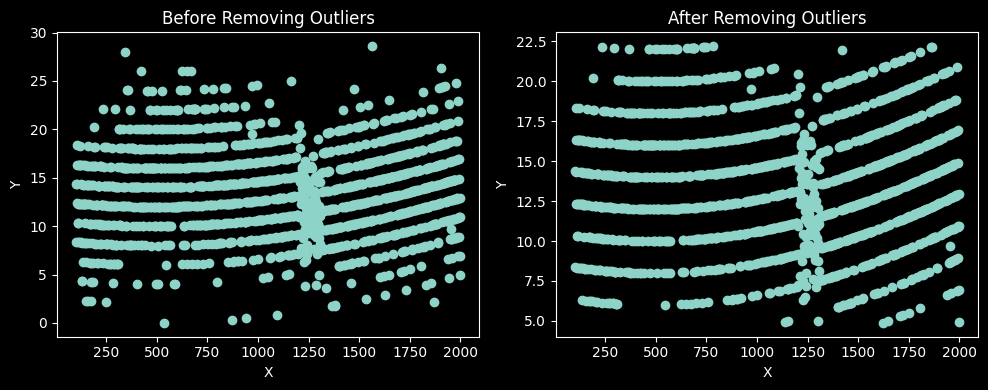

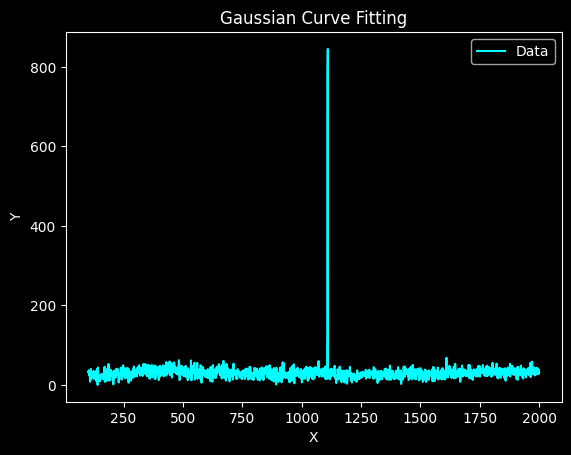

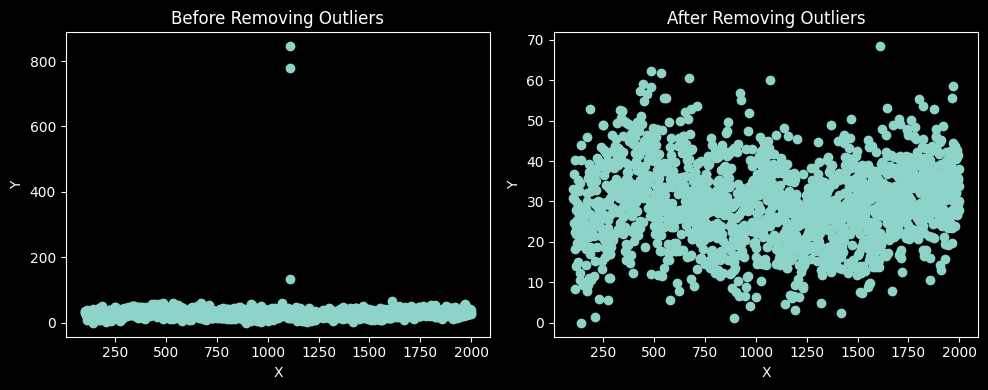

In [19]:
for f in files:
    r = RamanSpectrum(f)
    a,b = fit_raman(r)
    plot_removed(a,b,2)

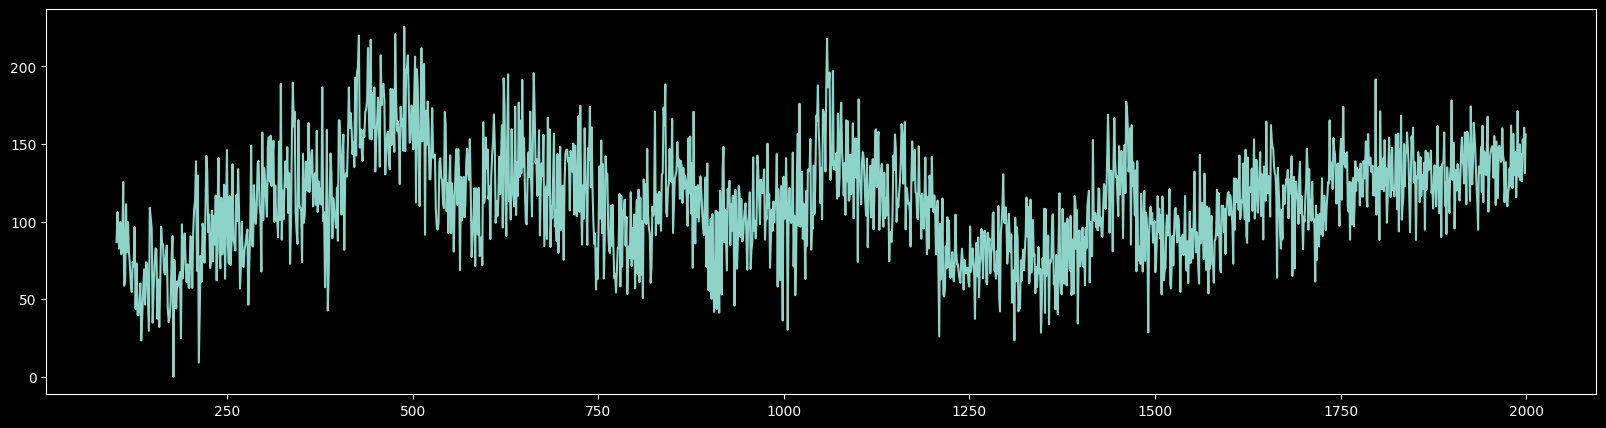

In [58]:
yp = y_data - y_fit
mm = min(yp)
yp = yp - mm

# Ploting the data with h and w as width and height respectively
h = 5
w = 20
plt.figure(figsize=(w, h))
plt.plot(x_data, yp)

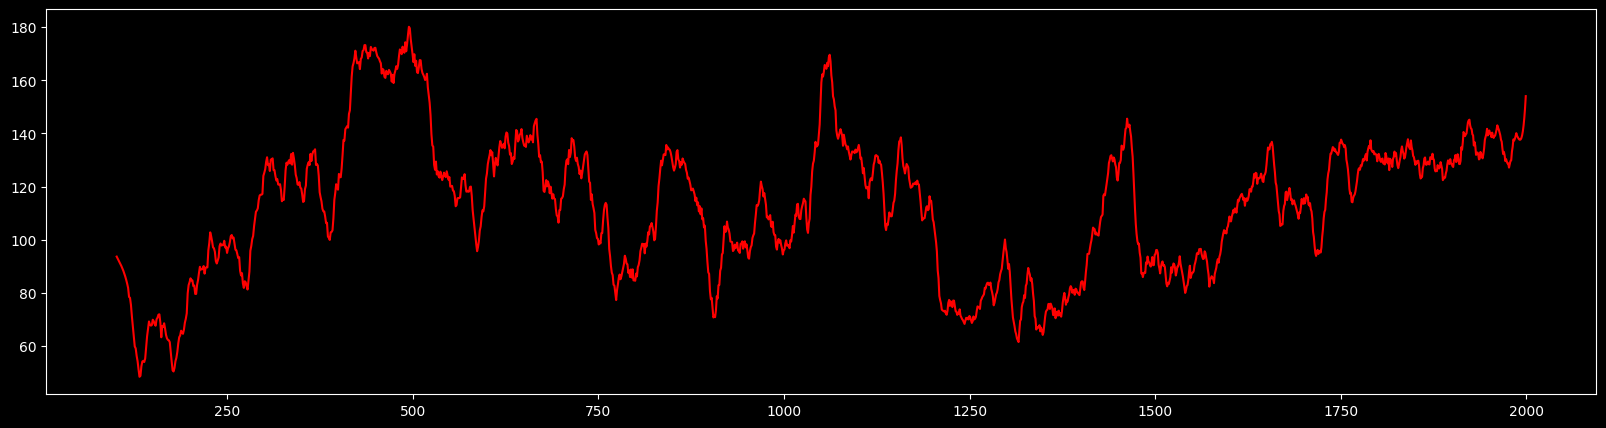

In [83]:
# now we define u and v as x_data and yp respectively

u = x_data
v = yp

# After this we apply the Savitzky-Golay filter

from scipy.signal import savgol_filter
vhat = savgol_filter(v, 25, 3) # window size 51, polynomial order 3

# Ploting the data with h and w as width and height respectively
h = 5
w = 20
plt.figure(figsize=(w, h))
plt.plot(u, vhat, color='red')

In [ ]:
def rinterv(a,b):
    return [i for i in range(a,b)]

a = rinterv(258,260)
b = rinterv(463,465)
c = rinterv(770,773)
d = rinterv(1977,1980)
e = rinterv(170,172)

f = [a,b,c,d,e]

xpo, ypo = test.plotpoints(f)

test.crop(150,1000,show=True)